In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

model = keras.models.load_model('../models/retinal_disease_classifier.keras')
print("Model loaded successfully!")

X_val = np.load('../data/processed/X_val.npy')
y_val = np.load('../data/processed/y_val.npy')

print(f"Validation data loaded: {X_val.shape}, {y_val.shape}")

/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.12/site-packages/keras/src/export/tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


Model loaded successfully!
Validation data loaded: (384, 512, 512, 3), (384, 45)


In [3]:
y_pred_probs = model.predict(X_val)

print(f"Predictions shape: {y_pred_probs.shape}")
print(f"Prediction range: {y_pred_probs.min():.3f} to {y_pred_probs.max():.3f}")

print(f"\nFirst image predictions (probabilities for 45 diseases):")
print(y_pred_probs[0])

y_pred_binary = (y_pred_probs >= 0.5).astype(int)

print(f"\nBinary predictions shape: {y_pred_binary.shape}")
print(f"First image binary predictions:")
print(y_pred_binary[0])
print(f"True labels:")
print(y_val[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step
Predictions shape: (384, 45)
Prediction range: 0.000 to 0.522

First image predictions (probabilities for 45 diseases):
[0.26056018 0.07687557 0.16430648 0.11263262 0.0589396  0.04426975
 0.10783049 0.01134241 0.03111291 0.00937451 0.02080117 0.20398465
 0.01678259 0.00371653 0.00801605 0.06636521 0.03241611 0.00407323
 0.00689978 0.0046256  0.00876907 0.0424219  0.01583762 0.01060361
 0.01210997 0.00892025 0.0040831  0.00394855 0.00203013 0.00138759
 0.00244013 0.00184149 0.00074    0.0030475  0.00275805 0.00057786
 0.00169837 0.00358658 0.00109619 0.0016291  0.0016412  0.00278333
 0.00177055 0.00121409 0.00196343]

Binary predictions shape: (384, 45)
First image binary predictions:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]
True labels:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0]


In [4]:
train_labels = pd.read_csv("../data/raw/Training_Set/RFMiD_Training_Labels.csv")
disease_names = train_labels.columns[2:47].tolist()

from sklearn.metrics import roc_auc_score

disease_aucs = []
for i, disease in enumerate(disease_names):
    try:
        auc = roc_auc_score(y_val[:, i], y_pred_probs[:, i])
        disease_aucs.append(auc)
    except:
        disease_aucs.append(np.nan)  

results_df = pd.DataFrame({
    'Disease': disease_names,
    'AUC': disease_aucs
})
results_df = results_df.sort_values('AUC', ascending=False)

print("Top 10 best performing diseases:")
print(results_df.head(10))
print("\nBottom 10 worst performing diseases:")
print(results_df.tail(10))

Top 10 best performing diseases:
   Disease       AUC
17      ST  0.958225
24    RPEC  0.847368
4      MYA  0.807769
18    AION  0.773560
20      RT  0.762533
34      TD  0.749347
21      RS  0.727513
0       DR  0.710994
14      AH  0.694444
22     CRS  0.672399

Bottom 10 worst performing diseases:
   Disease  AUC
28      CB  NaN
29    ODPM  NaN
30     PRH  NaN
32      HR  NaN
37      CF  NaN
38      VH  NaN
40      VS  NaN
41    BRAO  NaN
42     PLQ  NaN
44      CL  NaN


/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/Retinal Disease Classifier/venv/lib/python3.12/site-packages/sklearn/metrics/_ranking.py:442: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
/Users/ananthkini/Documents/

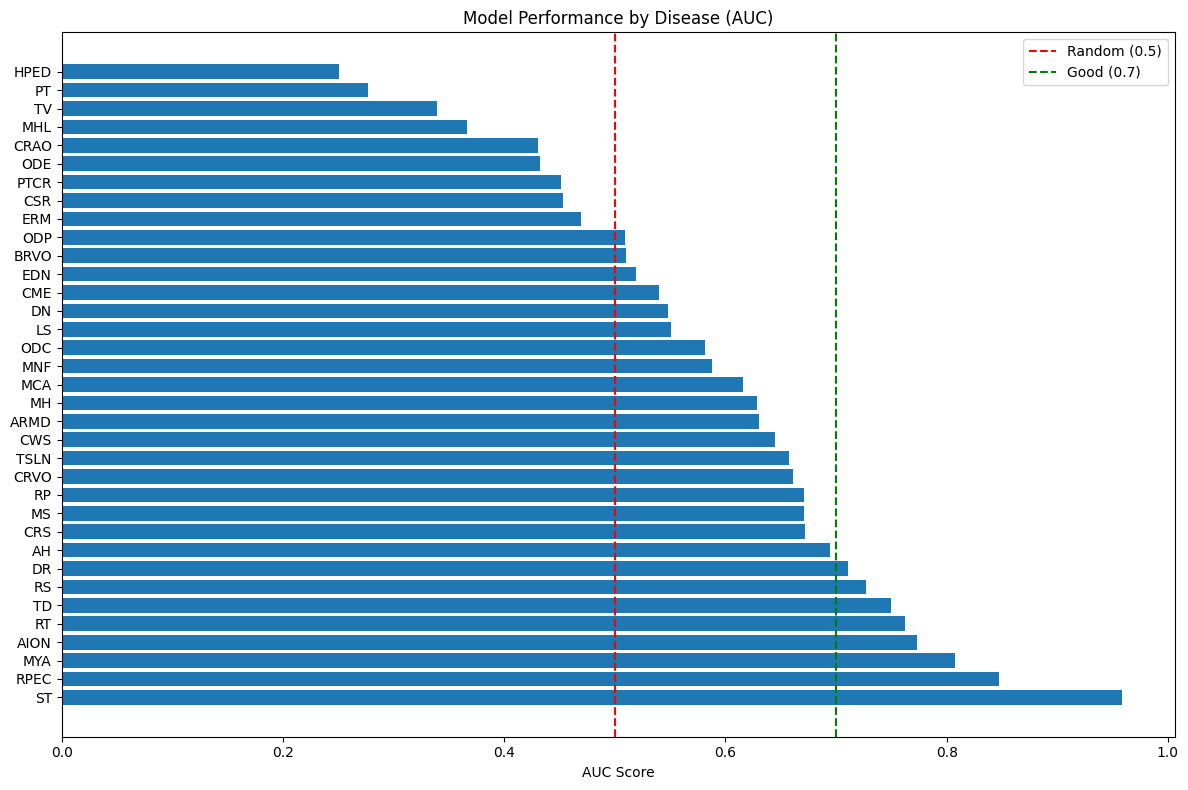


Average AUC across diseases with data: 0.591


In [5]:
# Filter out NaN values
results_clean = results_df.dropna()

# Plot
plt.figure(figsize=(12, 8))
plt.barh(results_clean['Disease'], results_clean['AUC'])
plt.xlabel('AUC Score')
plt.title('Model Performance by Disease (AUC)')
plt.axvline(x=0.5, color='r', linestyle='--', label='Random (0.5)')
plt.axvline(x=0.7, color='g', linestyle='--', label='Good (0.7)')
plt.legend()
plt.tight_layout()
plt.savefig('../results/disease_performance.png')
plt.show()

print(f"\nAverage AUC across diseases with data: {results_clean['AUC'].mean():.3f}")